In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random

from redTools import *
from Kcorrect import *

from matplotlib import rcParams
rcParams["font.size"] = 14
rcParams["text.usetex"] = True
rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"


####################################### Plotting Function
def makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='test'):

    fig = py.figure(figsize=(17, 5), dpi=100)    
    fig.subplots_adjust(wspace=0, top=0.92, bottom=0.12, left=0.06, right=0.98)
    gs = gridspec.GridSpec(1, 3, width_ratios=[1,1,1]) 
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax3 = plt.subplot(gs[2])
    ax_list  = [ax1,ax2,ax3]
    x0 = 0.9*xlim[0]+0.1*xlim[1]
    y0 = 0.15*ylim[0]+0.85*ylim[1]    

    delta = y_trn-p_y_trn
    ax = ax_list[0]
    ax.plot(y_trn, delta, 'g.', alpha=0.3)
    ax.set_title('Training Set', fontsize=18)
    ax.set_ylabel(ylabel, fontsize=16)
    ax.text(x0,y0, 'RMS = '+'%.2f'%np.std(delta), fontsize=16, color='k')
    
    delta = y_cvl-p_y_cvl
    ax = ax_list[1]
    ax.plot(y_cvl, delta, 'r.', alpha=0.7)
    ax.set_title('Cross Validation Set', fontsize=18)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.text(x0,y0, 'RMS = '+'%.2f'%np.std(delta), fontsize=16, color='k')

    delta = y_tst-p_y_tst
    ax = ax_list[2]
    ax.plot(y_tst, delta, 'b.', alpha=0.7)
    ax.set_title('Test Set', fontsize=18)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.text(x0,y0, 'RMS = '+'%.2f'%np.std(delta), fontsize=16, color='k')


    for ax in ax_list:
        
        ax.set_xlabel(xlabel, fontsize=16)
        ax.plot(xlim, [0,0], 'k:')
        ax.set_ylim(ylim)
        ax.set_xlim(xlim) 
        ax.tick_params(which='major', length=6, width=1.5, direction='in')
        ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')  

        y_ax = ax.twinx()
        y_ax.set_ylim(ylim)
        y_ax.set_yticklabels([])
        y_ax.minorticks_on()
        y_ax.tick_params(which='major', length=6, width=1.5, direction='in')
        y_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')        

        x_ax = ax.twiny()
        x_ax.set_xlim(xlim)
        x_ax.set_xticklabels([])
        x_ax.minorticks_on()
        x_ax.tick_params(which='major', length=6, width=1.0, direction='in')
        x_ax.tick_params(which='minor', length=4, color='#000033', width=1.0, direction='in')     

        for tick in ax.xaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 
        for tick in ax.yaxis.get_major_ticks():
                    tick.label.set_fontsize(14) 

    fig.savefig(plotName+".png")
    plt.show()
#######################################

In [3]:
## loading data
inFile = 'ESN_INC_P0_MAG.csv'
table = np.genfromtxt(inFile , delimiter=',', filling_values=-1, names=True, dtype=None)

In [115]:
## Sample management
## table_tst: Test table
## table_cvl: Cross Validation table
## table_trn: Training Table
## N_test: Number of test data points
## N_cross: Number of cross validation data points
## Seed_test: Random seed number to choose the test sample (i.e. fixed=0)
## Seed_cross: Random seed number to choose the cross validation sample 
##                     (can be changed to see the algorithm performance)
table_tst, table_cvl, table_trn = prepareSamples(table, Seed_cross=300)


Feature Importances:  [0.10100714 0.05501443 0.84397842]
g_r  --> 10.10%
r_i  --> 5.50%
mu50  --> 84.40%


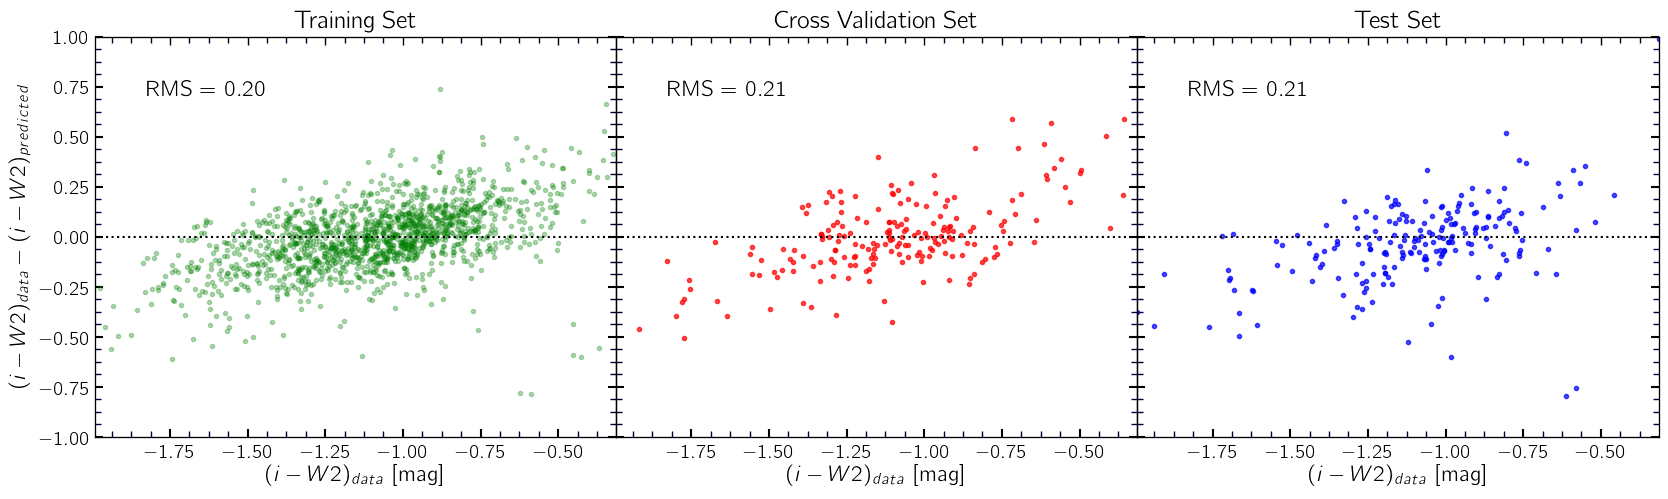

In [116]:
################################ Feature selection, regression parameters
features = ['g_r', 'r_i', 'mu50']
output   = 'i_w2'
max_depth=2000
n_estimators=2000
max_features=3
min_samples_leaf=10
bootstrap=True
################################ Regression (Random Forest)
regr, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr.feature_importances_
print 'Feature Importances: ', importances
for j in range(len(features)):
    print features[j], ' --> '+'%.2f'%(importances[j]*100)+'%'

################################ Plotting
text     = 'i-W2'
text_unit = 'mag'
x0 = np.min(table_tst[output])
x1 = np.max(table_tst[output])
xlabel = r'$('+text+')'+'_{data}$'+'   ['+text_unit+']'
ylabel = r'$('+text+')'+'_{data}'+'-'+'('+text+')'+'_{predicted}$'
xlim = [x0,x1]
ylim = [-1,1]
makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='RF_grI_mu50')

[0.07053432 0.02836876 0.89638229]


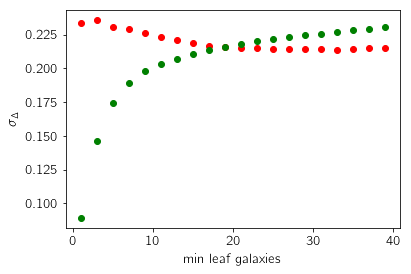

In [128]:
nLeaf = np.arange(1,40,2)
Seeds = range(30)
Stdev_trn = np.ones(shape = (len(nLeaf),len(Seeds)))
Stdev_cvl = np.ones(shape = (len(nLeaf),len(Seeds)))
importance = np.ones(shape = (len(Seeds),3))

for j in range(len(Seeds)):
    
    table_tst, table_cvl, table_trn = prepareSamples(table, Seed_cross=Seeds[j])

    ################################ Feature selection, regression parameters
    features = ['g_r', 'r_i', 'mu50']
    output   = 'i_w2'
    n_estimators=1000
    max_depth = 2000
    max_features=3
    bootstrap=True
    ################################ Regression (Random Forest)

    for k in range(len(nLeaf)):
        regr, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
            table_tst, table_cvl, table_trn, \
                features, output, \
                    max_features=max_features, min_samples_leaf=nLeaf[k], bootstrap=bootstrap)
        Stdev_cvl[k][j]  = np.std(y_cvl-p_y_cvl)
        Stdev_trn[k][j] = np.std(y_trn-p_y_trn)
        importance[j] = regr.feature_importances_.T

plt.plot(nLeaf, np.median(Stdev_cvl,1), 'ro')
plt.plot(nLeaf, np.median(Stdev_trn,1), 'go')
plt.xlabel('min leaf galaxies',fontsize=14)
plt.ylabel(r'$\sigma_\Delta$',fontsize=14)
print np.median(importance.T,1)

plt.show()

Feature Importances:  [0.20571112 0.13772524 0.65656364]
g_r  --> 20.57%
r_i  --> 13.77%
mu50  --> 65.66%


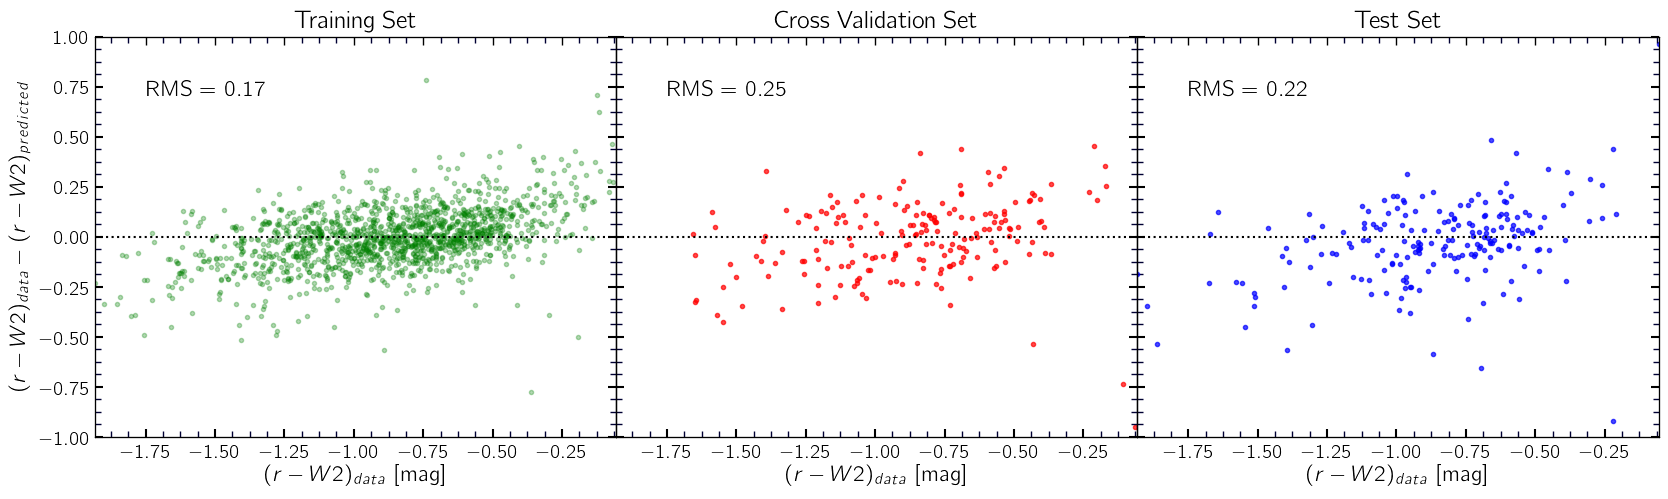

In [77]:
################################ Feature selection, regression parameters
features = ['g_r', 'r_i', 'mu50']
output   = 'r_w2'
max_depth=2000
n_estimators=2000
max_features=3
min_samples_leaf=5
bootstrap=True
################################ Regression (Random Forest)
regr, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr.feature_importances_
print 'Feature Importances: ', importances
for j in range(len(features)):
    print features[j], ' --> '+'%.2f'%(importances[j]*100)+'%'

################################ Plotting
text     = 'r-W2'
text_unit = 'mag'
x0 = np.min(table_tst[output])
x1 = np.max(table_tst[output])
xlabel = r'$('+text+')'+'_{data}$'+'   ['+text_unit+']'
ylabel = r'$('+text+')'+'_{data}'+'-'+'('+text+')'+'_{predicted}$'
xlim = [x0,x1]
ylim = [-1,1]
makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='RF_gRi_mu50')

Feature Importances:  [0.17564062 0.11939707 0.06646917 0.63849314]
g_r  --> 17.56%
r_i  --> 11.94%
i_z  --> 6.65%
mu50  --> 63.85%


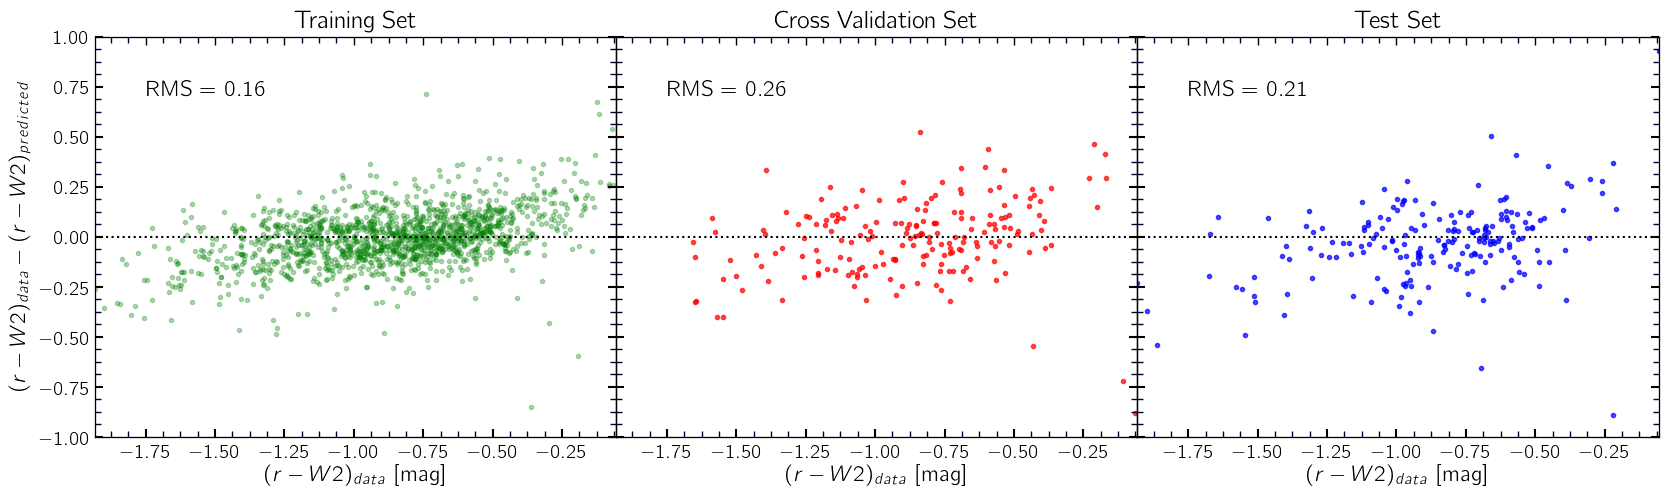

In [80]:
################################ Feature selection, regression parameters
features = ['g_r', 'r_i', 'i_z', 'mu50']
output   = 'r_w2'
max_depth=2000
n_estimators=2000
max_features=4
min_samples_leaf=5
bootstrap=True
################################ Regression (Random Forest)
regr, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr.feature_importances_
print 'Feature Importances: ', importances
for j in range(len(features)):
    print features[j], ' --> '+'%.2f'%(importances[j]*100)+'%'

################################ Plotting
text     = 'r-W2'
text_unit = 'mag'
x0 = np.min(table_tst[output])
x1 = np.max(table_tst[output])
xlabel = r'$('+text+')'+'_{data}$'+'   ['+text_unit+']'
ylabel = r'$('+text+')'+'_{data}'+'-'+'('+text+')'+'_{predicted}$'
xlim = [x0,x1]
ylim = [-1,1]
makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='RF_gRiz_mu50')

Feature Importances:  [0.76588033 0.02218425 0.03382241 0.06659467 0.0863045  0.02521383]
g_r 	-->  76.59%
r_i 	-->  2.22%
i_z 	-->  3.38%
r_w2 	-->  6.66%
mu50 	-->  8.63%
logWimx -->  2.52%


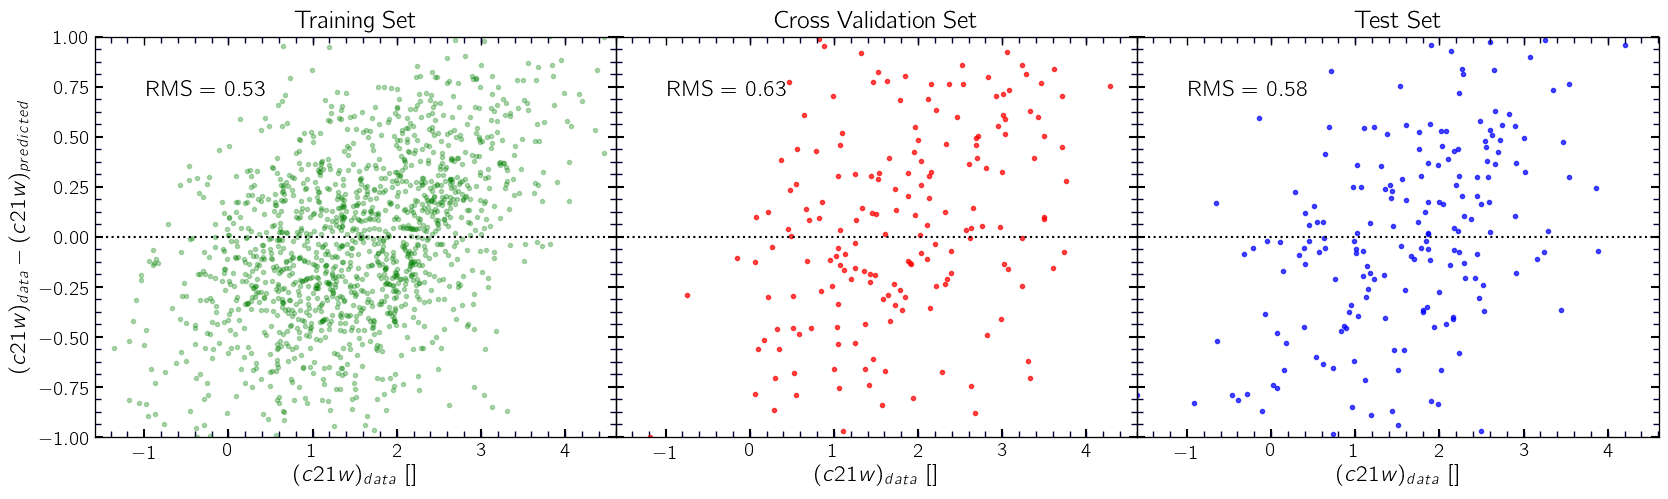

In [67]:
## Sample management
table_tst, table_cvl, table_trn = prepareSamples(table, Seed_cross=150)
################################ Feature selection, regression parameters
features = ['g_r', 'r_i', 'i_z', '', 'mu50', 'logWimx']
output   = 'c21w'
max_depth=2000
n_estimators=2000
max_features=len(features)
min_samples_leaf=10
bootstrap=True
################################ Regression (Random Forest)
regr, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr.feature_importances_
print 'Feature Importances: ', importances
for j in range(len(features)):
    if features[j]!='logWimx':
        print features[j], '\t-->  '+'%.2f'%(importances[j]*100)+'%'
    else: print features[j], '-->  '+'%.2f'%(importances[j]*100)+'%'

################################ Plotting
text     = output
text_unit = ''
x0 = np.min(table_tst[output])
x1 = np.max(table_tst[output])
xlabel = r'$('+text+')'+'_{data}$'+'   ['+text_unit+']'
ylabel = r'$('+text+')'+'_{data}'+'-'+'('+text+')'+'_{predicted}$'
xlim = [x0,x1]
ylim = [-1,1]
makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='RF_grIz_mu50_logWimx_c21w')

28700 90 -0.264 13.292
50 13.55321053534692 [-4.4408921e-16]
Delta W: 0.26
0.05974406575954694
0.04201093474708539
0.004271703702255603
-0.05349405783130645


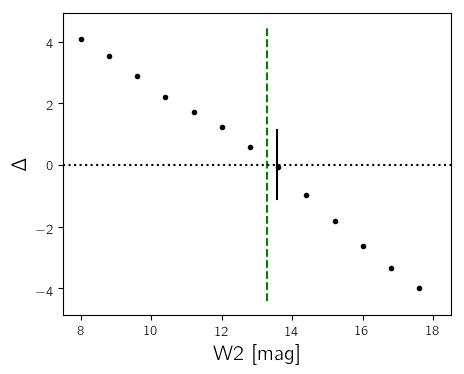

In [68]:
j = 10
PGC = table_tst['pgc'][j]
W2  = table_tst['w2'][j]
INC = table_tst["inc"][j]
P0  = table_tst["pc0"][j]
M21 = table["m21"][j]
M0  = table["logWimx"][j]
WBA = table["Wba"][j]
R50 = table["R50_w2"][j]
print PGC, INC, P0, W2
def f(w2):
    return predictor(w2, table_tst, regr, features, output, index=j)
###############################################
fig = py.figure(figsize=(5, 4), dpi=100)  
ax = fig.add_subplot(111)

for w2 in np.arange(8,18,0.8):
    delta = f(w2)
    ax.plot([w2], [delta], 'k.')

xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.plot([W2,W2], [ylim[0],ylim[1]], 'g--')
ax.plot([7.5,18.5], [0,0], 'k:')    
ax.set_xlim([7.5,18.5])
ax.set_xlabel('W2 [mag]', fontsize=15)
ax.set_ylabel(r'$\Delta$', fontsize=15)
###############################################

out = solver(f, 8, 18, threshold=0.001) 
if out==None:
    print 'Not solvable ... !!!'
else:
    w2p, N = out
    w2p=w2p[0]
    print N, w2p, f(w2p)    
    print 'Delta W: '+'%.2f'%np.abs(w2p-W2)
    _, _, _, P0p = get_PC(w2p, M21, M0, WBA, R50)
    print redCorrect(INC, P0p, band1='g', band2='w2')-redCorrect(INC, P0, band1='g', band2='w2')
    print redCorrect(INC, P0p, band1='r', band2='w2')-redCorrect(INC, P0, band1='r', band2='w2')
    print redCorrect(INC, P0p, band1='i', band2='w2')-redCorrect(INC, P0, band1='i', band2='w2')
    print redCorrect(INC, P0p, band1='z', band2='w2')-redCorrect(INC, P0, band1='z', band2='w2')
    ax.plot([w2p,w2p], [ylim[0]/4.,ylim[1]/4.], 'k-') 



plt.show()

Feature Importances:  [0.3409674  0.48368181 0.17535079]
g_r  --> 34.10%
r_i  --> 48.37%
i_z  --> 17.54%


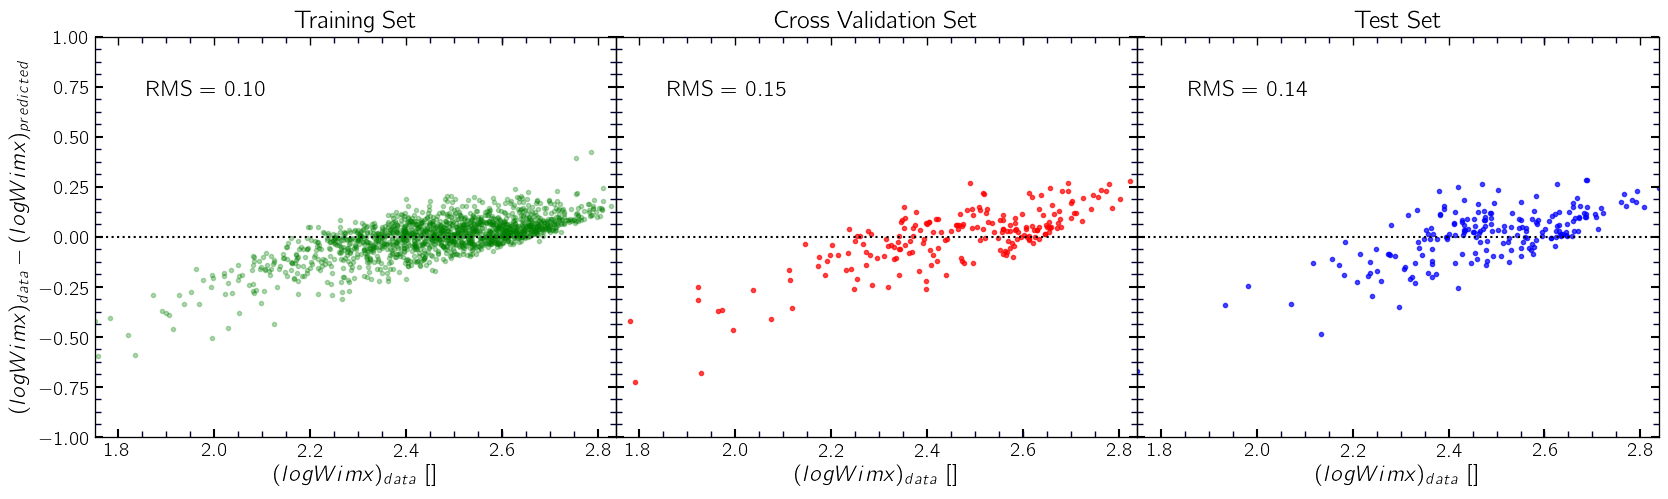

In [85]:
################################ Feature selection, regression parameters
features = ['g_r', 'r_i', 'i_z']
output   = 'logWimx'
max_depth=2000
n_estimators=2000
max_features=3
min_samples_leaf=5
bootstrap=True
################################ Regression (Random Forest)
regr, x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst = esn_RForest( \
    table_tst, table_cvl, table_trn, \
        features, output, \
            max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=bootstrap)
importances = regr.feature_importances_
print 'Feature Importances: ', importances
for j in range(len(features)):
    print features[j], ' --> '+'%.2f'%(importances[j]*100)+'%'

################################ Plotting
text     = 'logWimx'
text_unit = ''
x0 = np.min(table_tst[output])
x1 = np.max(table_tst[output])
xlabel = r'$('+text+')'+'_{data}$'+'   ['+text_unit+']'
ylabel = r'$('+text+')'+'_{data}'+'-'+'('+text+')'+'_{predicted}$'
xlim = [x0,x1]
ylim = [-1,1]
makePlot(x_trn, y_trn, p_y_trn, x_cvl, y_cvl, p_y_cvl, x_tst, y_tst, p_y_tst, \
        xlim, ylim, xlabel, ylabel, plotName='RF_griz_logWimx')